<a href="https://colab.research.google.com/github/ArtemMusienko/LoRA-SD-Generator/blob/main/LoRA_SD_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LoRA-SD-Generator

**LoRA-SD-Generator** — это личный исследовательский проект по тонкой настройке (**fine-tuning**) модели `Stable Diffusion 1.5` с использованием метода **LoRA** (**Low-Rank Adaptation**) для генерации стилизованных лиц по текстовым описаниям.

*Цель проекта* — создать лёгкую, эффективную и воспроизводимую модель, которая способна генерировать высококачественные стилизованные портреты, сохраняя при этом низкое потребление ресурсов (работа велась исключительно в **Google Colab** с **GPU T4**).

## Установка и импорт необходимых библиотек и настроек:

Этот блок кода подготавливает рабочую среду для обучения нейросетей типа **Stable Diffusion**.

**Stable Diffusion** — это современная генеративная нейросеть с открытым исходным кодом, предназначенная для создания высококачественных изображений на основе текстовых описаний, а также для редактирования уже существующих картинок. В отличие от некоторых закрытых аналогов, она работает по принципу диффузионной модели, процесс которой заключается в постепенном превращении случайного цифрового шума в четкое, осмысленное изображение путем многократного уточнения деталей на основе весов обученной модели. Основная техническая особенность Stable Diffusion заключается в использовании латентного пространства, что позволяет проводить сложные вычисления не с самими пикселями напрямую, а с их сжатым математическим представлением; это делает систему невероятно эффективной и позволяет запускать ее даже на домашних компьютерах с потребительскими видеокартами.

Здесь загружаются «кирпичики», на которых держится проект:

*   `diffusers`: главная библиотека для работы с диффузионными моделями;
*   `transformers`: база для текстовых энкодеров (чтобы нейросеть понимала ваши слова);
*   `accelerate`: магия от Hugging Face, которая помогает коду работать на GPU максимально эффективно.

Вместо того чтобы просто использовать установленную версию, мы копируем весь репозиторий с **GitHub**. Это нужно, чтобы получить доступ к папке `examples`. В ней лежат уже готовые скрипты для **LoRA** (дообучение на ваших лицах или стилях), которых нет в стандартном пакете `pip`.







In [1]:
# Блок установки всех библиотек (выполняется один раз в сессии; -q для тихой установки, --upgrade для обновлений)
!pip install -q --upgrade diffusers transformers accelerate datasets ftfy gradio clean-fid torchmetrics

# Клонирование и установка diffusers для доступа к example-скриптам LoRA/DreamBooth)
!git clone https://github.com/huggingface/diffusers
%cd diffusers
!pip install .

# Конфигурация Accelerate (default для mixed precision fp16 — экономит VRAM на T4)
!accelerate config default

fatal: destination path 'diffusers' already exists and is not an empty directory.
/content/diffusers
Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.37.0.dev0-py3-none-any.whl size=4915667 sha256=14ddde0fc55c208678d02fccebe528f0e85941f7933376aa85a7b6023135d197
  Stored in directory: /tmp/pip-ephem-wheel-cache-b0gpspr2/wheels/8a/fc/09/385efb77b455b2fd4a656c950079c93147e1f50ae614e51beb
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.37.0.dev0
    Uninstalling diffusers-0.37.0.dev0:
      Successfully uninstalled diffusers-0.37.0.dev0
Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


Далее перейдем к импорту библиотек, описание которых представлены в виде комментариев в самом коде:

In [2]:
import os  # Для работы с путями и директориями
import shutil  # Для копирования/удаления файлов/папок
import json
import random
import numpy as np

from IPython.display import display, HTML  # Для показа изображений/HTML в ноутбуке

import torch
from diffusers import DiffusionPipeline  # Для Stable Diffusion пайплайна/LoRA
from datasets import load_dataset  # Для загрузки датасетов с HF (CelebA)

from transformers import BlipProcessor, BlipForConditionalGeneration, CLIPProcessor, CLIPModel # BlipProcessor + BlipForConditionalGeneration — процессор и модель BLIP (Salesforce) для генерации описаний изображений (image-to-text/captioning)
                                                                                               # CLIPProcessor + CLIPModel — процессор и модель CLIP (OpenAI) для расчёта семантической схожести текст-изображение (используется в manual CLIP score)

from PIL import Image  # Для открытия/сохранения изображений
import glob  # Для поиска файлов по маске (*.jpg)

import gradio as gr # Для интерфейса

from cleanfid import fid  # Для FID (cleanfid — фикс для совместимости с Python 3.12; нестандартная: альтернатива torch-fid)
from torchmetrics.multimodal.clip_score import CLIPScore  # Для CLIP score (torchmetrics — нестандартная: часть PyTorch для метрик)

# Для авторизации на HuggingFace
from huggingface_hub import login
from google.colab import userdata

from google.colab import drive # Для Google Drive

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


Этот код выполняет привязку вашего облачного хранилища Google Drive к виртуальной машине для обеспечения сохранности данных и автоматического создания структуры рабочих директорий. Сначала команда монтирует диск, превращая его в доступный раздел файловой системы, а затем с помощью модуля os создается основная папка проекта и три подпапки для обучающих изображений, хранения итоговых весов обученной модели и сохранения тестовых результатов генерации. Использование параметра `exist_ok=True` позволяет избежать системных ошибок при повторном запуске ячейки, гарантируя, что все этапы обучения — от загрузки датасета до получения финального файла — будут надежно зафиксированы в облаке и не пропадут после завершения сессии в браузере.

In [3]:
drive.mount('/content/drive')

# Создадим папки для организации проекта на Drive
project_dir = '/content/drive/MyDrive/LoRA-SD-Project'
os.makedirs(project_dir, exist_ok=True)
os.makedirs(os.path.join(project_dir, 'dataset'), exist_ok=True)
os.makedirs(os.path.join(project_dir, 'lora_model'), exist_ok=True)
os.makedirs(os.path.join(project_dir, 'generated_images'), exist_ok=True)

print(f"Папки созданы в: {project_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Папки созданы в: /content/drive/MyDrive/LoRA-SD-Project


Далее проверяем техническую готовность системы к тяжелым вычислениям, подтверждая наличие и работоспособность видеокарты (**GPU**). Сначала с помощью библиотеки `PyTorch` переменной device присваивается значение `cuda`, если графический ускоритель доступен, или `cpu`, если расчеты придется вести на обычном процессоре (чего для обучения **Stable Diffusion** недостаточно). Затем команда `!nvidia-smi` запрашивает у драйвера **NVIDIA** системную таблицу, которая показывает точную модель видеокарты, объем занятой и свободной видеопамяти, а также текущую температуру. Это критически важный этап, так как он позволяет убедиться, что выделенная вам в облаке видеокарта (например, **Tesla T4**) обладает необходимыми **15–16 ГБ** видеопамяти для успешного запуска процесса дообучения нейросети:

In [4]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

!nvidia-smi  # Выводит информацию о GPU (VRAM ~15GB на T4)

Device: cuda
Wed Jan 28 10:59:41 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+----------------------------------

Этот код выполняет автоматическую авторизацию на платформе **Hugging Face**, используя систему безопасного хранения секретов **Google Colab**. Он извлекает ваш персональный токен из переменной `HF_TOKEN`, чтобы вы могли скачивать защищенные модели или загружать свои обученные результаты в облако без необходимости вводить пароль вручную при каждом запуске.

Как получить свой `HF_TOKEN`?

1. Зайдите на сайт и создайте аккаунт;
2. Перейдите в **Settings** (Настройки) своего профиля, нажав на аватарку в правом верхнем углу;
3. Выберите в меню слева раздел **Access Tokens**;
4. Нажмите кнопку **Create new token**;
5. Дайте токену любое **имя** (например, "Colab") и выберите тип **Write** (чтобы иметь возможность не только скачивать, но и сохранять модели);
6. Скопируйте полученный длинный код.

Как загрузить ключ в **Google Colab**?

1. В левой панели **Colab** (где иконки папки и поиска) нажмите на иконку ключа (раздел "**Secrets**");
2. Нажмите **Add new secret**;
3. В поле **Name** введите: `HF_TOKEN`;
4. В поле **Value** вставьте скопированный с сайта **ключ**;
5. Обязательно включите переключатель "**Notebook access**" (Разрешить доступ блокноту) рядом с созданным секретом.

In [5]:
# Получаем токен из Secrets Colab (имя секрета: 'HF_TOKEN')
hf_token = userdata.get('HF_TOKEN')
if hf_token:
    login(hf_token)
    print("Успешно авторизован в Hugging Face.")
else:
    print("Токен 'HF_TOKEN' не найден в Secrets. Пропустите, если не требуется авторизация.")

Успешно авторизован в Hugging Face.


Этот фрагмент кода отвечает за автоматическую подготовку данных для обучения: он скачивает готовый набор фотографий и сохраняет их в созданную ранее папку на вашем **Google Drive**:

In [6]:
# Путь к папке датасета
dataset_dir = os.path.join(project_dir, 'dataset')

# Загрузка датасета CelebA
dataset = load_dataset("nielsr/CelebA-faces", split="train[:500]")

# Сохранение изображений в папку
for idx, item in enumerate(dataset):
    image = item['image']
    image_path = os.path.join(dataset_dir, f"celeb_{idx:04d}.jpg")
    image.save(image_path)

print(f"Загружено {len(dataset)} изображений в {dataset_dir}")

Загружено 500 изображений в /content/drive/MyDrive/LoRA-SD-Project/dataset


Процесс происходит в два этапа:

1. Создание функции-обработчика: Она открывает каждый файл, принудительно переводит его в цветовое пространство **RGB** (удаляя прозрачность или лишние каналы), и изменяет размер до **512x512** пикселей. Использование фильтра `LANCZOS` гарантирует, что при уменьшении картинки сохранятся мелкие детали и резкость;

2. Массовая обработка: С помощью модуля `glob` программа находит все **.jpg файлы** в папке датасета и по очереди прогоняет их через функцию, перезаписывая оригиналы уже «правильными» версиями.

Это критически важный шаг, так как нейросеть обучается на тензорах строго определенного размера, и наличие картинок разного разрешения или формата (например, ч/б или PNG с прозрачностью) привело бы к ошибке в процессе тренировки.

In [7]:
# Функция для ресайза и конвертации
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")  # Конверт в RGB
    img = img.resize((512, 512), Image.LANCZOS)  # Ресайз с качеством
    img.save(image_path)  # Перезаписываем

# Обработка всех изображений в папке
image_files = glob.glob(os.path.join(dataset_dir, "*.jpg"))
for img_path in image_files:
    preprocess_image(img_path)

print(f"Обработано {len(image_files)} изображений. Все в 512x512 RGB.")

Обработано 1000 изображений. Все в 512x512 RGB.


Этот код выполняет автоматическое «аннотирование» датасета: нейросеть **BLIP** смотрит на каждое изображение и описывает словами то, что на ней изображено.Сначала программа загружает модель **BLIP** в режиме fp16 на видеокарту, что позволяет быстро анализировать изображения, не переполняя память. Затем для каждого файла в папке вызывается функция генерации текста (captioning), которая превращает визуальные данные в текстовую строку.

К полученному описанию добавляется специальный префикс (в данном случае "a stylized face:"). В финале все пары «имя файла — описание» упаковываются в формат `JSONL`. Это создает своего рода «словарь» для процесса обучения: когда **Stable Diffusion** начнет тренироваться, она будет открывать картинку и одновременно читать созданный файл метаданных, чтобы понять, какой визуальный ряд соответствует вашему текстовому запросу.

In [8]:
# Загрузка модели BLIP
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base", torch_dtype=torch.float16)
model.to("cuda")  # На GPU

# Функция для генерации caption
def generate_caption(image_path):
    image = Image.open(image_path)
    inputs = processor(image, return_tensors="pt").to("cuda", torch.float16)
    out = model.generate(**inputs, max_new_tokens=50)  # Генерация
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

# Генерация для всех изображений и сохранение в JSONL
metadata_path = os.path.join(dataset_dir, 'metadata.jsonl')
with open(metadata_path, 'w') as f:
    for img_path in image_files:
        file_name = os.path.basename(img_path)
        caption = generate_caption(img_path)
        # Кастомизация caption (добавим префикс для personalization, e.g., "a stylized face of")
        customized_caption = f"a stylized face: {caption}"
        json.dump({"file_name": file_name, "text": customized_caption}, f)
        f.write('\n')

print(f"Captions сгенерированы и сохранены в {metadata_path}. Пример: {customized_caption}")

The image processor of type `BlipImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights:   0%|          | 0/473 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie text_decoder.cls.predictions.bias to text_decoder.cls.predictions.decoder.bias, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
The tied weights mapping and config for this model specifies to tie text_decoder.bert.embeddings.word_embeddings.weight to text_decoder.cls.predictions.decoder.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning
BlipForConditionalGeneration LOAD REPORT from: Salesforce/blip-image-captioning-base
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
text_decoder.bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identic

Captions сгенерированы и сохранены в /content/drive/MyDrive/LoRA-SD-Project/dataset/metadata.jsonl. Пример: a stylized face: a woman with her hair in a ponytail


Этот код выполняет роль финальной проверки (валидации) перед тем, как вы отправите модель на долгое обучение. Его задача — визуально подтвердить, что предыдущие этапы подготовки данных и генерации описаний прошли без ошибок.

Пример caption: a stylized face: a woman with long blonde hair and a black top


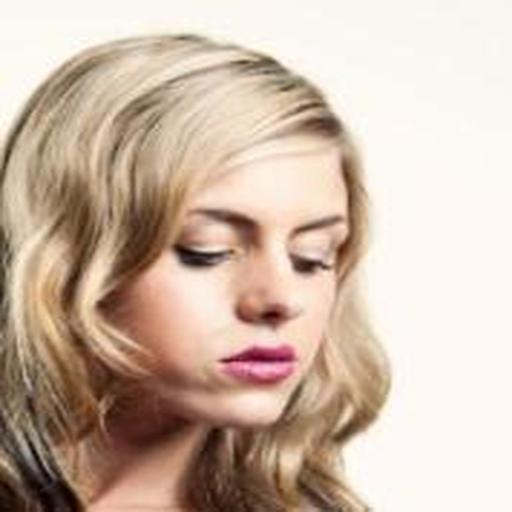

In [9]:
# Выбор случайного примера
random_img_path = random.choice(image_files)
with open(metadata_path, 'r') as f:
    metadata = [json.loads(line) for line in f]
random_meta = next(m for m in metadata if m['file_name'] == os.path.basename(random_img_path))

print(f"Пример caption: {random_meta['text']}")
img = Image.open(random_img_path)
display(img)  # Отобразит в Colab

Этот код выполняет «уборку» в видеопамяти (**VRAM**) перед началом самого ресурсоемкого этапа — обучения нейросети.

Сначала команда `del model` удаляет объект нейросети **BLIP** из оперативной памяти, а `torch.cuda.empty_cache()` принудительно очищает кэш видеокарты, возвращая зарезервированную память системе. Завершающий вызов `!nvidia-smi` позволяет вам лично убедиться, что память освободилась.

In [10]:
del model
torch.cuda.empty_cache()

!nvidia-smi  # Проверь VRAM (должна быть почти пустая)

Wed Jan 28 11:04:42 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P0             31W /   70W |     154MiB /  15360MiB |     26%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Этот блок кода выполняет финальную логистику и подготовку файлов непосредственно перед запуском процесса обучения. Он настраивает пути, управляет сохранением прогресса и устраняет возможные технические конфликты.

Сначала скрипт определяет папки для сохранения готовой модели и вспомогательных данных. Важной частью является работа с переменной `resume`: если она включена, код сохраняет предыдущие наработки, а если выключена — полностью очищает папку output_dir для чистого старта. Ключевым моментом здесь выступает «фикс» для файла метаданных: код временно перемещает `metadata.jsonl` из папки с изображениями, чтобы основной скрипт обучения случайно не попытался прочитать текстовый файл как изображение, что вызвало бы ошибку. В конце блок проверяет наличие самого файла скрипта `train_dreambooth_lora.py` в склонированном репозитории, подтверждая, что всё готово к запуску команды обучения.

In [11]:
# Пути
output_dir = os.path.join(project_dir, 'lora_model')
class_data_dir = os.path.join(project_dir, 'class_images')

resume = True

# Удаляем старый output_dir, если resume = False
if os.path.exists(output_dir) and not resume:
    shutil.rmtree(output_dir)
    print("Старый output_dir удалён для чистого запуска.")

# Создаём директории
os.makedirs(output_dir, exist_ok=True)
os.makedirs(class_data_dir, exist_ok=True)

# Временное перемещение metadata
metadata_path = os.path.join(dataset_dir, 'metadata.jsonl')
temp_metadata = os.path.join(project_dir, 'temp_metadata.jsonl')
if os.path.exists(metadata_path):
    shutil.move(metadata_path, temp_metadata)
    print(f"Metadata.jsonl перемещён временно в {temp_metadata} для избежания ошибки.")

# Путь к скрипту (из клонированного diffusers)
script_path = '/content/diffusers/examples/dreambooth/train_dreambooth_lora.py'

# Если скрипт не найден, убедимся
if not os.path.exists(script_path):
    print("Скрипт не найден! Проверьте клонирование diffusers в этапе 1.")
else:
    print(f"Скрипт готов: {script_path}")

Metadata.jsonl перемещён временно в /content/drive/MyDrive/LoRA-SD-Project/temp_metadata.jsonl для избежания ошибки.
Скрипт готов: /content/diffusers/examples/dreambooth/train_dreambooth_lora.py


Этот блок кода формирует строку аргументов (`args`) для запуска скрипта обучения **LoRA-модели** в **Stable Diffusion** (скрипт `train_dreambooth_lora.py `из репозитория **diffusers**).

*   `MODEL_NAME `— имя базовой модели **Stable Diffusion 1.5** (зеркало оригинальной версии);

*   `args` — это строка, которая передаётся в командную строку `accelerate launch`. Каждый параметр начинается с -- и передаётся в формате f-строки;

*   Если включён `resume=True`, добавляется флаг возобновления обучения с последнего чекпоинта;

*   В конце выводится сообщение о готовности параметров.










In [12]:
# Модель base — базовая предобученная Stable Diffusion 1.5 (зеркало официальной версии)
MODEL_NAME = "sd-legacy/stable-diffusion-v1-5"

# Аргументы для скрипта train_dreambooth_lora.py
args = (
    # Путь к базовой модели (обязательный параметр)
    f"--pretrained_model_name_or_path={MODEL_NAME} "

    # Папка с обучающими изображениями (нашими лицами из датасета)
    f"--instance_data_dir={dataset_dir} "

    # Папка с регуляризационными (class) изображениями — генерируются скриптом
    f"--class_data_dir={class_data_dir} "

    # Куда сохранять обученные LoRA-веса и чекпоинты
    f"--output_dir={output_dir} "

    # Разрешение, к которому приводятся все изображения перед обучением
    f"--resolution=512 "                    # 512×512 — стандарт для SD 1.5

    # Размер батча на шаг (1 — минимальный, чтобы влезть в память T4)
    f"--train_batch_size=1 "

    # Накопление градиентов — эффективный батч = 1 × 4 = 4
    f"--gradient_accumulation_steps=4 "

    # Скорость обучения (learning rate) — стандартное значение для LoRA
    f"--learning_rate=1e-4 "

    # Планировщик скорости обучения — cosine плавно снижает LR к концу
    f"--lr_scheduler=cosine "

    # Количество шагов разогрева LR (0 — без разогрева)
    f"--lr_warmup_steps=0 "

    # Общее количество шагов обучения — основной параметр длительности
    f"--max_train_steps=3000 "

    # Ранг LoRA-матриц (A и B) — 16 даёт хороший баланс качества и размера
    f"--rank=16 "

    # Использование смешанной точности fp16 — сильно экономит VRAM
    f"--mixed_precision=fp16 "

    # Сохранять чекпоинт каждые N шагов — удобно для возобновления
    f"--checkpointing_steps=100 "

    # Включить prior preservation (регуляризация через class-изображения)
    f"--with_prior_preservation "

    # Вес регуляризации — 0.5 делает адаптацию сильнее, чем при 1.0
    f"--prior_loss_weight=0.5 "

    # Единый текстовый промпт для всех обучающих изображений
    f"--instance_prompt='a photo of a stylized face' "

    # Промпт для сгенерированных class-изображений (регуляризация)
    f"--class_prompt='a photo of a face' "

    # Сколько class-изображений сгенерировать для prior preservation
    f"--num_class_images=100 "

    # Фиксированный сид для воспроизводимости результатов
    f"--seed=42 "

    # Дообучать также text encoder (CLIP) — улучшает понимание промптов
    f"--train_text_encoder "
)

# Если включено возобновление — добавляем флаг к последнему чекпоинту
if resume:
    args += f" --resume_from_checkpoint=latest "
    print("Resumption включено.")

print("Параметры настроены.")

Resumption включено.
Параметры настроены.


Следующий код отвечает за запуск обучения **LoRA-модели** и проверку результатов после завершения (или прерывания) процесса.

* `!accelerate launch` — запускает скрипт в ускоренном режиме с поддержкой нескольких GPU/процессов (в **Colab** — один** T4 GPU**);
* `--mixed_precision="fp16"` — включает режим смешанной точности (**float16**) — сильно экономит видеопамять и ускоряет обучение на **GPU**;
* {script_path} — путь к скрипту обучения (обычно /content/diffusers/examples/dreambooth/train_dreambooth_lora.py);
* {args} — строка со всеми параметрами обучения (`MODEL_NAME, dataset_dir, rank=16, max_train_steps=3000` и т.д.), которую мы формировали раньше.

**Colab** запускает скрипт `train_dreambooth_lora.py` с нашими настройками. Обучение начинается (или возобновляется, если есть `--resume_from_checkpoint`). Процесс может идти от нескольких минут до нескольких часов — в зависимости от количества шагов и размера датасета.







In [13]:
# Запуск обучения
!accelerate launch --mixed_precision="fp16" {script_path} {args}

# Проверка сохранения после обучения (финальные weights и чекпоинты)
weights_path = os.path.join(output_dir, 'pytorch_lora_weights.safetensors')
if os.path.exists(weights_path):
    print(f"Fine-tuning завершён успешно! Финальные LoRA weights сохранены в {weights_path}.")
    # Список чекпоинтов (для ручного resumption, если нужно)
    checkpoints = [d for d in os.listdir(output_dir) if d.startswith('checkpoint-')]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=lambda x: int(x.split('-')[1]))
        print(f"Доступные чекпоинты: {checkpoints}. Последний: {latest_checkpoint} (используйте для manual resumption).")
else:
    print("Обучение прервано или ошибка — проверь логи. Чекпоинты сохранены в {output_dir} для resumption.")
    # Если прервано, всё равно перечисли чекпоинты
    checkpoints = [d for d in os.listdir(output_dir) if d.startswith('checkpoint-')]
    if checkpoints:
        print(f"Сохранённые чекпоинты: {checkpoints}. Установите resume=True и перезапустите для продолжения.")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
{'sample_max_value', 'variance_type', 'thresholding', 'timestep_spacing', 'clip_sample_range', 'prediction_type', 'dynamic_thresholding_ratio', 'rescale_betas_zero_snr'} was not found in config. Values will be initialized to default values.
Loading weights: 100% 196/196 [00:00<00:00,

Этот небольшой блок кода выполняет финальную «уборку» после завершения (или прерывания) процесса обучения модели в **Google Colab**. Он решает две простые, но важные задачи: возвращает на место временно перемещённый файл и очищает видеопамять **GPU**.

Сначала проверяется, существует ли временный файл **temp_metadata** (это **metadata.jsonl**, который мы ранее переместили в другое место, чтобы скрипт обучения не пытался открыть его как картинку и не упал с ошибкой). Если файл есть — он перемещается обратно в исходную папку датасета (**dataset_dir**) с помощью `shutil.move`. После этого выводится сообщение-подтверждение, что **metadata.jsonl** вернулся на место.

Далее вызывается `torch.cuda.empty_cache()` — эта команда просит **PyTorch** освободить неиспользуемый кэш видеопамяти **CUDA**. Во время обучения (особенно в **fp16-режиме**) **GPU** резервирует много памяти под промежуточные тензоры и буферы; даже после удаления моделей часть этой памяти остаётся «занятой». `empty_cache()` возвращает её системе, чтобы последующие запуски (например, инференс или новый эксперимент) не столкнулись с ошибкой **OutOfMemory**.

В конце запускается команда `!nvidia-smi` — она выводит текущее состояние **GPU**: сколько памяти занято/свободно, какие процессы висят, загрузка ядра. Это позволяет быстро убедиться, что память действительно освободилась

In [14]:
# Возвращаем metadata.jsonl обратно в dataset_dir
if os.path.exists(temp_metadata):
    shutil.move(temp_metadata, metadata_path)
    print(f"Metadata.jsonl возвращён в {metadata_path}.")

torch.cuda.empty_cache()

!nvidia-smi  # Должна показать освобождённую память

Metadata.jsonl возвращён в /content/drive/MyDrive/LoRA-SD-Project/dataset/metadata.jsonl.
Wed Jan 28 11:06:14 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P0             29W /   70W |     154MiB /  15360MiB |      2%      Default |
|                                         |       

Сначала создаётся путь к папке **generated_images** (куда будут сохраняться сгенерированные картинки) и эта папка создаётся, если её ещё нет (`exist_ok=True` предотвращает ошибку, если папка уже существует).

Затем задаются две ключевые переменные:

1. `MODEL_NAME` — имя базовой модели **Stable Diffusion 1.5** (зеркало оригинальной версии, чтобы избежать проблем с доступом);

2. `weights_path` — путь к файлу с дообученными **LoRA-весами** (`pytorch_lora_weights.safetensors`), который был сохранён после обучения.

Дальше идёт проверка: если файл весов не найден — выводится сообщение об ошибке (чтобы пользователь сразу понял, что обучение не завершилось или файл пропал).
Если файл на месте — загружается пайплайн:

1. `DiffusionPipeline.from_pretrained` — загружает базовую модель в формате **float16** (экономит видеопамять);
2. `pipe.to("cuda")` — переносит модель на **GPU**;
3. `pipe.load_lora_weights` — подгружает именно **LoRA-адаптер** (маленький файл с изменениями, а не всю модель заново).

In [15]:
generated_dir = os.path.join(project_dir, 'generated_images')  # Для сгенерированных изображений
os.makedirs(generated_dir, exist_ok=True)

# Base модель + LoRA
MODEL_NAME = "sd-legacy/stable-diffusion-v1-5"
weights_path = os.path.join(output_dir, 'pytorch_lora_weights.safetensors')  # Финальные weights

# Проверка существования weights
if not os.path.exists(weights_path):
    print("Ошибка: LoRA weights не найдены! Проверьте обучение.")
else:
    pipe = DiffusionPipeline.from_pretrained(MODEL_NAME, torch_dtype=torch.float16)
    pipe = pipe.to("cuda")
    pipe.load_lora_weights(weights_path)
    print("Модель загружена.")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

CLIPTextModel LOAD REPORT from: /root/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/text_encoder
Key                                | Status     |  | 
-----------------------------------+------------+--+-
text_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

StableDiffusionSafetyChecker LOAD REPORT from: /root/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592e9a14/safety_checker
Key                                               | Status     |  | 
--------------------------------------------------+------------+--+-
vision_model.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/96 [00:00<?, ?it/s]

Модель загружена.


Этот блок кода читает файл с описаниями изображений (**metadata.jsonl**), выбирает из него до 50 случайных текстовых промптов, а затем использует уже загруженную модель **Stable Diffusion + LoRA** для генерации 50 изображений по этим промптам, сохраняет их в специальную папку и выводит итоговое сообщение о количестве сгенерированных файлов.

Также можете раскомментировать часть кода после вывода итогов, который выведет вам пример сгенерированного промпта и изображения.

In [16]:
# Читаем файл с описаниями изображений (metadata.jsonl) — каждая строка это JSON с именем файла и текстом
metadata_path = os.path.join(dataset_dir, 'metadata.jsonl')
with open(metadata_path, 'r') as f:
    metadata = [json.loads(line) for line in f]  # Преобразуем каждую строку в словарь

# Выбираем до 50 случайных промптов из метаданных (для оценки качества — FID/CLIP)
# random.sample — гарантирует отсутствие повторов
prompts = [m['text'] for m in random.sample(metadata, min(50, len(metadata)))]

# Список для хранения путей к сгенерированным изображениям
generated_paths = []

# Генерируем изображения по выбранным промптам
for idx, prompt in enumerate(prompts):
    # Запускаем модель: 75 шагов — баланс качества и скорости, guidance 7.5 — классическое значение
    image = pipe(prompt, num_inference_steps=75, guidance_scale=7.5).images[0]

    # Формируем путь с номером (0000, 0001 и т.д.) для удобной сортировки
    gen_path = os.path.join(generated_dir, f"generated_{idx:04d}.jpg")

    # Сохраняем изображение на диск
    image.save(gen_path)

    # Добавляем путь в список — пригодится для метрик (FID, CLIP)
    generated_paths.append(gen_path)

# Выводим итог — сколько изображений сгенерировано и куда они сохранены
print(f"Сгенерировано {len(generated_paths)} изображений в {generated_dir}.")

# # Пример до/после
# base_pipe = DiffusionPipeline.from_pretrained(MODEL_NAME, torch_dtype=torch.float16).to("cuda")
# example_prompt = prompts[0]
# base_image = base_pipe(example_prompt, num_inference_steps=75, guidance_scale=7.5).images[0]
# fine_image = pipe(example_prompt, num_inference_steps=75, guidance_scale=7.5).images[0]

# display(HTML(f"<b>Промпт:</b> {example_prompt}<br><b>Base:</b>"))
# display(base_image)
# display(HTML("<b>Fine-tuned:</b>"))
# display(fine_image)

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

Сгенерировано 50 изображений в /content/drive/MyDrive/LoRA-SD-Project/generated_images.


Далее рассчитаем две метрики качества генеративной модели: **FID** и **CLIP Score**. Сначала он задаёт пути к реальным и сгенерированным изображениям и запускает функцию `clean-fid` для вычисления **FID** (чем ниже значение — тем ближе сгенерированные картинки к оригинальному датасету). Затем загружает модель **CLIP** (**base-patch32**) и вручную вычисляет **CLIP Score** — для каждой пары «промпт — изображение» получает эмбеддинги текста и картинки, нормализует их, считает косинусное сходство и выводит среднее значение по всем 50 изображениям (чем выше — тем лучше модель понимает текст). Это надёжный способ оценки, когда **torchmetrics CLIPScore** падает с ошибкой.

In [17]:
# Пути к реальным и сгенерированным изображениям (для FID)
real_images_dir = dataset_dir
gen_images_dir = generated_dir

# Расчёт FID — сравнивает распределение реальных и сгенерированных изображений
# mode="clean" — наиболее точный вариант, num_workers=0 — без многопоточности в Colab
fid_score = fid.compute_fid(real_images_dir, gen_images_dir, mode="clean", num_workers=0)
print(f"FID score: {fid_score:.2f}")

# Загружаем CLIP-модель и процессор (base-patch32 — стабильная версия без ошибок нормализации)
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to('cuda')
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

clip_scores_manual = []
for i, p in enumerate(generated_paths):
    img = Image.open(p).resize((224, 224))  # Подготовка изображения под вход CLIP
    inputs = clip_processor(text=prompts[i], images=img, return_tensors="pt", padding=True).to('cuda')
    outputs = clip_model(**inputs)

    # Ручная L2-нормализация эмбеддингов (чтобы посчитать косинусное сходство)
    img_emb = outputs.image_embeds / outputs.image_embeds.norm(dim=-1, keepdim=True)
    text_emb = outputs.text_embeds / outputs.text_embeds.norm(dim=-1, keepdim=True)

    # Косинусное сходство между изображением и текстом
    similarity = (img_emb * text_emb).sum(dim=-1)
    clip_scores_manual.append(similarity.item())

# Среднее значение CLIP score по всем парам (выше — лучше семантическое соответствие)
avg_clip = sum(clip_scores_manual) / len(clip_scores_manual)
print(f"Avg CLIP score (manual): {avg_clip:.2f}")

compute FID between two folders
Found 1000 images in the folder /content/drive/MyDrive/LoRA-SD-Project/dataset


FID dataset : 100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


Found 52 images in the folder /content/drive/MyDrive/LoRA-SD-Project/generated_images


FID generated_images : 100%|██████████| 2/2 [00:04<00:00,  2.49s/it]


FID score: 149.66


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Avg CLIP score (manual): 0.28


Этот блок создаёт красивый веб-интерфейс на **Gradio** с использованием `gr.Blocks` для генерации изображений **Stable Diffusion + LoRA**: основные поля для промпта и negative prompt, кнопки "Сгенерировать" и "Случайный промпт" (выбирает из prompts), аккордеон с доп. настройками (шаги, guidance, сила img2img, исходное изображение), функция `generate_image` поддерживает **text-to-image** и **img2img**.

In [18]:
# Функция генерации изображения (поддерживает два режима — text-to-image и img2img; параметры по умолчанию для простоты использования)
def generate_image(prompt, negative, steps, guidance, strength, init_img):
    # Проверяем, загружено ли исходное изображение (если да — переходим в img2img-режим для стилизации)
    if init_img is not None:
        # Запускаем пайплайн в img2img (strength контролирует силу изменений — 0.1 слабые, 1.0 сильные)
        return pipe(
            prompt=prompt,
            image=init_img,                          # Исходное изображение для преобразования
            strength=strength,                       # Степень преобразования (от 0.1 до 1.0)
            negative_prompt=negative,                # Отрицательный промпт для исключения элементов
            num_inference_steps=int(steps),          # Количество шагов диффузии (int для безопасности)
            guidance_scale=guidance                  # Сила следования промпту
        ).images[0]  # Возвращаем первое (и единственное) изображение из батча
    else:
        # Стандартный text-to-image режим (без исходного изображения — полная генерация с нуля)
        return pipe(
            prompt=prompt,
            negative_prompt=negative,
            num_inference_steps=int(steps),
            guidance_scale=guidance
        ).images[0]  # Возвращаем первое изображение

# Функция для случайного промпта
def random_prompt():
    return random.choice(prompts)


with gr.Blocks(theme=gr.themes.Soft(primary_hue="blue", secondary_hue="gray")) as demo:
    gr.Markdown("# Fine-tuned LoRA Stable Diffusion")

    with gr.Row():
        with gr.Column(scale=2):
            prompt = gr.Textbox(
                label="Промпт",
                placeholder="a stylized face: a woman with blue eyes",
                lines=3,
                autofocus=True  # Автофокус на поле
            )
            negative = gr.Textbox(
                label="Нежелательные элементы",
                placeholder="blurry, low quality",
                lines=2
            )
            btn = gr.Button("Сгенерировать", variant="primary")  # Кнопка генерации
            btn_random = gr.Button("Случайный промпт")  # Кнопка для случайного промпта

        with gr.Column(scale=1):
            output = gr.Image(label="Результат")

    # Дополнительные настройки (по умолчанию закрыты)
    with gr.Accordion("Дополнительные настройки", open=False):
        steps = gr.Slider(20, 150, value=75, step=5, label="Шаги")
        guidance = gr.Slider(1.0, 20.0, value=7.5, step=0.5, label="Сила следования промпту")
        strength = gr.Slider(0.1, 1.0, value=0.75, step=0.05, label="Степень преобразования")
        init_img = gr.Image(label="Исходное изображение", type="pil")

    # Клик по кнопкам
    btn.click(generate_image, inputs=[prompt, negative, steps, guidance, strength, init_img], outputs=output)
    btn_random.click(random_prompt, outputs=prompt)  # Заполняет поле промпта случайным значением

demo.launch(share=True)

/tmp/ipython-input-2906538586.py:28: UserWarning: The parameters have been moved from the Blocks constructor to the launch() method in Gradio 6.0: theme. Please pass these parameters to launch() instead.
  with gr.Blocks(theme=gr.themes.Soft(primary_hue="blue", secondary_hue="gray")) as demo:


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://915c00726260dde9ee.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
